In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn import tree
import pydotplus

## Importing dataset

In [3]:
hel = pd.read_csv('train_data.csv')
hel.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


## Data wrangling

### Deleting useless ID variables

- "case_id" and "patientid" wiil be no use for our analysis, we can delete the column first.

In [82]:
# hel = hel.drop(columns=['case_id','patientid'])

In [5]:
hel.groupby(by='Stay')['Stay'].count().sort_values()

Stay
61-70                  2744
91-100                 2765
81-90                  4838
More than 100 Days     6683
71-80                 10254
41-50                 11743
0-10                  23604
51-60                 35018
31-40                 55159
11-20                 78139
21-30                 87491
Name: Stay, dtype: int64

In [6]:
print(pd.DataFrame(hel).dtypes)

case_id                                int64
Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
patientid                              int64
City_Code_Patient                    float64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object


### Checking missing values

- Let us check NaN values in this train data set.

In [7]:
hel.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [8]:
print("Rate of missing value for Bed Grade:",
      round(hel['Bed Grade'].isnull().sum()/len(hel) * 100, 2),"%")
print("Rate of missing value for City_Code_Patient:",
      round(hel['City_Code_Patient'].isnull().sum()/len(hel) * 100, 2),"%")


Rate of missing value for Bed Grade: 0.04 %
Rate of missing value for City_Code_Patient: 1.42 %


- Noted that only "Bed Grade" and "City_Code_Patient" have missing values. Let us dive deeper into these two variables.

1. Bed Grade

In [9]:
print(hel.groupby(by='Bed Grade')['Bed Grade'].count().sort_values())
print("Number of types:",len(hel.groupby(by='Bed Grade')))

Bed Grade
1.0     26505
4.0     57566
3.0    110583
2.0    123671
Name: Bed Grade, dtype: int64
Number of types: 4


- With 113 missing values, the variable "Bed Grade" has 4 types of items. The rate of missing values is quite low for this variable. Therefore, we choose to delete observations with missing values of "Bed Grade".

In [10]:
hel = hel.dropna(subset=["Bed Grade"])
hel = hel.reset_index(drop = True)

2. City_Code_Patient

- With as many as 4532 missing values, it is hard to use variable "City_Code_Patient" for our analysis, so it is better to delete this column from the data set.

In [11]:
hel = hel.drop(columns = ['City_Code_Patient'])

### Working with useless variables

- Let us check each column's values in detail.

In [12]:
for i in hel.columns:
    print(hel.groupby(by = i)[i].count())
    print("Number of types:",len(hel.groupby(by=i)),'\n')

case_id
1         1
2         1
3         1
4         1
5         1
         ..
318434    1
318435    1
318436    1
318437    1
318438    1
Name: case_id, Length: 318325, dtype: int64
Number of types: 318325 

Hospital_code
1      5249
2      5102
3      7116
4      1240
5      5261
6     20316
7      1303
8      3663
9     11510
10     9435
11    17328
12    11297
13     5236
14    17328
15     9257
16     3671
17     5501
18     3630
19    21218
20     1405
21     8150
22     4277
23    26566
24     7992
25     9834
26    33076
27    14244
28    17137
29    11311
30     5002
31     3967
32    10703
Name: Hospital_code, dtype: int64
Number of types: 32 

Hospital_type_code
a    143312
b     68946
c     45928
d     20389
e     24770
f     10703
g      4277
Name: Hospital_type_code, dtype: int64
Number of types: 7 

City_Code_Hospital
1     55351
2     51809
3     31569
4     13854
5     31105
6     46882
7     35462
9     26277
10     5249
11    17137
13     3630
Name: City_Code_Hospit

From information above, we can take each value of variables as string data type except variable ***Admission Deposit***, which is continuous values.Let us check its distribution.

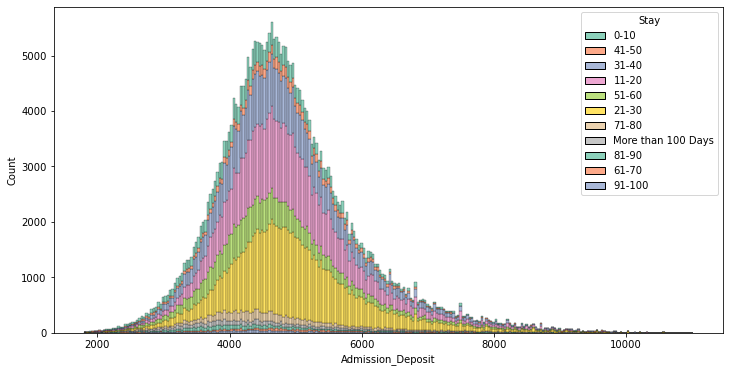

In [14]:
fig, ax = plt.subplots(figsize = (12,6))    
sns.histplot(x = 'Admission_Deposit', data = hel, hue = "Stay",palette = 'Set2', multiple = "stack")
plt.show()

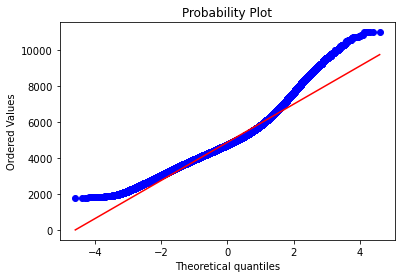

In [15]:
stats.probplot(hel['Admission_Deposit'],dist = 'norm',plot = pylab)
pylab.show()

- Noted that the distribution of "Admission_Deposit" is non-normal.

We need to divide this continuous variable into categories, let try dividing with quantile, curve slope and k-means clustering.

<AxesSubplot:>

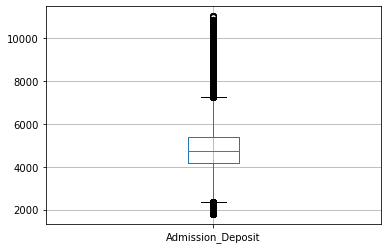

In [16]:
hel.boxplot(column = 'Admission_Deposit')

In [17]:
hel['Admission_Deposit'].describe()

count    318325.000000
mean       4880.857705
std        1086.848051
min        1800.000000
25%        4186.000000
50%        4741.000000
75%        5409.000000
max       11008.000000
Name: Admission_Deposit, dtype: float64

In [126]:
## by quantile

Admission = []
q1 = np.percentile(hel["Admission_Deposit"], 25)
q2 = np.percentile(hel["Admission_Deposit"], 50)
q3 = np.percentile(hel["Admission_Deposit"], 75)

for i in hel["Admission_Deposit"]:
    if i < q1:
        Admission.append('0-25%')
    elif i > q3:
        Admission.append('75-100%')
    elif i < q2 and i >= q1:
        Admission.append('25-50%')
    else:
        Admission.append('50-75%')
print(pd.value_counts(Admission))

50-75%     79732
25-50%     79578
75-100%    79527
0-25%      79488
dtype: int64


In [19]:
# by curve slope
labels = ['AD1','AD2','AD3','AD4']
n_cut = 4
l = np.array(hel['Admission_Deposit'].sort_values())
bins_thresh = [min(hel['Admission_Deposit'])] + list(l[i] for i in np.argsort((l[1:]-l[:-1]))[-(n_cut-1):]) + [max(l)]
adm = pd.cut(hel['Admission_Deposit'], bins = sorted(bins_thresh), labels = labels)

print(bins_thresh)
print(pd.value_counts(adm))

[1800.0, 10607.0, 10441.0, 10842.0, 11008.0]
AD1    318271
AD2        24
AD3        23
AD4         6
Name: Admission_Deposit, dtype: int64


'by curve slope' may not be a good method since the number of segment are vastly different.

In [20]:
# by clustering: AD only

kmeans = KMeans(n_clusters = 4)

X = np.array(hel['Admission_Deposit']).reshape(-1,1)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
# print(y_kmeans)

clist = np.array([y_kmeans[i] for i in hel['Admission_Deposit'].sort_values().index])

values, counts = np.unique(y_kmeans, return_counts = True)
print('values:', values)
print('counts:', counts)

mapping = np.append(clist[0], clist[1:][clist[1:] != clist[:-1]])
AD_clustering = [labels[int(np.where(mapping == i)[0])] for i in y_kmeans]
print(pd.value_counts(AD_clustering))

values: [0 1 2 3]
counts: [141585  81714  20913  74113]
AD2    141585
AD1     81714
AD3     74113
AD4     20913
dtype: int64


We take the outcome of dividing by k-means because it considers intra and internal distances.

In [21]:
tr_hel = hel.copy()
tr_hel["Admission_Deposit"] = AD_clustering

In [22]:
tr_hel.tail()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
318320,318434,6,a,6,X,3,radiotherapy,Q,F,4.0,86499,Emergency,Moderate,3,41-50,AD1,11-20
318321,318435,24,a,1,X,2,anesthesia,Q,E,4.0,325,Urgent,Moderate,4,81-90,AD4,31-40
318322,318436,7,a,4,X,3,gynecology,R,F,4.0,125235,Emergency,Minor,3,71-80,AD2,11-20
318323,318437,11,b,2,Y,3,anesthesia,Q,D,3.0,91081,Trauma,Minor,5,11-20,AD1,11-20
318324,318438,19,a,7,Y,5,gynecology,Q,C,2.0,21641,Emergency,Minor,2,11-20,AD2,0-10


## Data recoding

Now in order to use **Frequent Pattern Mining**, we need to make items from each variable unique, so we recode those variables with same items. For the column ***Hospital_code***, we add 100 for each value to make it differentiated from ***City_Code_Hospital*** and ***Visitors with Patient***.

In [190]:
# 1 ~ 32 --> 101 ~ 132

tr_hel["Hospital_code"] = tr_hel["Hospital_code"] + pd.Series([100]*len(hel))
tr_hel["Hospital_code"]

0         108
1         102
2         110
3         126
4         126
         ... 
318320    106
318321    124
318322    107
318323    111
318324    119
Name: Hospital_code, Length: 318325, dtype: int64

- For the column "City_Code_Hospital", we add 40 for each value to make it differentiated from "Visitors with Patient".

In [191]:
# 1 ~ 13 --> 41 ~ 53

tr_hel["City_Code_Hospital"] = tr_hel["City_Code_Hospital"]+pd.Series([40]*len(hel))
tr_hel["City_Code_Hospital"]

0         43
1         45
2         41
3         42
4         42
          ..
318320    46
318321    41
318322    44
318323    42
318324    47
Name: City_Code_Hospital, Length: 318325, dtype: int64

- For the column "Bed Grade", we change it to "b1", "b2", "b3" and "b4".

In [192]:
Bed_Grade_mapping = {1.0: "b1", 2.0: "b2", 3.0: "b3", 4.0: "b4"}
tr_hel.assign(BedGrade = tr_hel["Bed Grade"].map(Bed_Grade_mapping))

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,BedGrade
0,1,108,c,43,Z,3,radiotherapy,R,F,2.0,31397,Emergency,Extreme,2,51-60,AD2,0-10,b2
1,2,102,c,45,Z,2,radiotherapy,S,F,2.0,31397,Trauma,Extreme,2,51-60,AD3,41-50,b2
2,3,110,e,41,X,2,anesthesia,S,E,2.0,31397,Trauma,Extreme,2,51-60,AD2,31-40,b2
3,4,126,b,42,Y,2,radiotherapy,R,D,2.0,31397,Trauma,Extreme,2,51-60,AD4,41-50,b2
4,5,126,b,42,Y,2,radiotherapy,S,D,2.0,31397,Trauma,Extreme,2,51-60,AD3,41-50,b2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318320,318434,106,a,46,X,3,radiotherapy,Q,F,4.0,86499,Emergency,Moderate,3,41-50,AD1,11-20,b4
318321,318435,124,a,41,X,2,anesthesia,Q,E,4.0,325,Urgent,Moderate,4,81-90,AD4,31-40,b4
318322,318436,107,a,44,X,3,gynecology,R,F,4.0,125235,Emergency,Minor,3,71-80,AD2,11-20,b4
318323,318437,111,b,42,Y,3,anesthesia,Q,D,3.0,91081,Trauma,Minor,5,11-20,AD1,11-20,b3


In [193]:
tr_hel=tr_hel.drop(columns=['Bed Grade'])

- To differentiate ***Age*** and ***Stay***, we add ' d' to the values of ***Stay***.
- Add 'c' in front of the values of ***case_id***.
- Add 'p' in front of the values of ***patientid***.

In [194]:
stay=[]
for i in tr_hel["Stay"].values:
    stay.append(i+" d")
tr_hel["Stay"] = stay
caseid = []
for i in tr_hel["case_id"].values:
    caseid.append("c" + str(i))
tr_hel["case_id"] = caseid
patientid = []
for i in tr_hel["patientid"].values:
    patientid.append("p" + str(i))
tr_hel["patientid"] = patientid

- For the column ***City_Code_Hospital***, we add 40 for each value to make it differentiated from ***Visitors with Patient***.

In [195]:
tr_hel["Available Extra Rooms in Hospital"] = tr_hel["Available Extra Rooms in Hospital"]+pd.Series([60]*len(hel))
tr_hel["Available Extra Rooms in Hospital"]

0         63
1         62
2         62
3         62
4         62
          ..
318320    63
318321    62
318322    63
318323    63
318324    65
Name: Available Extra Rooms in Hospital, Length: 318325, dtype: int64

In [196]:
tr_hel.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,patientid,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,c1,108,c,43,Z,63,radiotherapy,R,F,p31397,Emergency,Extreme,2,51-60,AD2,0-10 d
1,c2,102,c,45,Z,62,radiotherapy,S,F,p31397,Trauma,Extreme,2,51-60,AD3,41-50 d
2,c3,110,e,41,X,62,anesthesia,S,E,p31397,Trauma,Extreme,2,51-60,AD2,31-40 d
3,c4,126,b,42,Y,62,radiotherapy,R,D,p31397,Trauma,Extreme,2,51-60,AD4,41-50 d
4,c5,126,b,42,Y,62,radiotherapy,S,D,p31397,Trauma,Extreme,2,51-60,AD3,41-50 d


- To make items in the frozenset be sorted, we need to convert those values of int type into string type.

In [155]:
def to_str(item):
    string=[]
    for i in range(len(item)):
        string.append(str(item[i]))
    return string

In [197]:
tr_hel["City_Code_Hospital"] = to_str(tr_hel["City_Code_Hospital"].values)
tr_hel["Available Extra Rooms in Hospital"] = to_str(tr_hel["Available Extra Rooms in Hospital"].values)
tr_hel["Visitors with Patient"] = to_str(tr_hel["Visitors with Patient"].values)
tr_hel["Hospital_code"] = to_str(tr_hel["Hospital_code"].values)

## Frequent Pattern Mining

For the frequent pattern mining analysis, we need first change the **Pandas.DataFrame** object into **list**.

In [171]:
records = tr_hel.values.tolist()

- Frequent Pattern Mining

Noted that we have a total of 143 frozensets, which equals to the sum of the number of types of all the variables.

We set the minimal Support threshold parameter as 0.04, meaning minimal support frequency equals to Number of observations * 0.04 = 12733.0. The reason why we choose 0.04 concerns the speed of running.

In [43]:
minSupport = 0.04  # minimal support threshold
len(records) * minSupport

12733.0

In [223]:
a = [1,2,3]
print(type(a) is not list)

False


In [113]:
def createC1(dataset, dropcols):
    if type(dataset) is not list:
        datasetdropped = dataset.drop(columns = dropcols, inplace = False)
        records = datasetdropped.values.tolist()
    else:
        records = dataset
    C1 = []
    for record in records:
        for item in record:
            if [item] not in C1:
                C1.append([item])
    try:
        C1.sort()
    except:
        pass
    return list(map(frozenset, C1))

In [114]:
C1 = createC1(tr_hel.iloc[:1000], ['case_id','patientid'])
print(C1)
print("Total number of frozenset: ", len(C1))

[frozenset({8}), frozenset({'c'}), frozenset({3}), frozenset({'Z'}), frozenset({'radiotherapy'}), frozenset({'R'}), frozenset({'F'}), frozenset({2.0}), frozenset({'Emergency'}), frozenset({'Extreme'}), frozenset({'51-60'}), frozenset({'AD2'}), frozenset({'0-10'}), frozenset({'< 1m'}), frozenset({5}), frozenset({'S'}), frozenset({'Trauma'}), frozenset({'AD3'}), frozenset({'41-50'}), frozenset({'1 - 2m'}), frozenset({10}), frozenset({'e'}), frozenset({1}), frozenset({'X'}), frozenset({'anesthesia'}), frozenset({'E'}), frozenset({'31-40'}), frozenset({26}), frozenset({'b'}), frozenset({'Y'}), frozenset({'D'}), frozenset({'AD4'}), frozenset({23}), frozenset({'a'}), frozenset({6}), frozenset({'11-20'}), frozenset({32}), frozenset({'f'}), frozenset({9}), frozenset({'B'}), frozenset({4}), frozenset({'Q'}), frozenset({'d'}), frozenset({'gynecology'}), frozenset({22}), frozenset({'g'}), frozenset({'Urgent'}), frozenset({'21-30'}), frozenset({nan}), frozenset({16}), frozenset({'A'}), frozenset({

In [106]:
def scanD(D, Ck, minSupport):
    ssCnt = {}
    for tid in D:
        for can in Ck:
            if can.issubset(tid):
                ssCnt[can] = ssCnt.get(can, 0) + 1
    numTrans = float(len(D))
    retList = []
    supportData = {}
    for key in ssCnt:
        support = ssCnt[key] / numTrans

        if support >= minSupport:
            retList.insert(0, key)

        supportData[key] = support
    return retList, supportData

In [107]:
def aprioriGen(Lk, k):
    retList = []
    lenLk = len(Lk) 
    for i in range(lenLk):
        for j in range(i + 1, lenLk):
            L1 = list(Lk[i])[: k - 2]
            L2 = list(Lk[j])[: k - 2]
            L1.sort()
            L2.sort()
            if L1 == L2:
                retList.append(Lk[i] | Lk[j])
    return retList

In [108]:
def apriori(dataset, minSupport, dropcols):
    # Initial
    if type(dataset) is not list:
        datasetdropped = dataset.drop(columns = dropcols, inplace = False)
        records = datasetdropped.values.tolist()
    else:
        records = dataset
    C1 = createC1(records, dropcols)
    D = list(map(set, records))

    # Initial frequent itemsets, containing one element
    L1, suppData = scanD(D, C1, minSupport)
    L = [L1]

    # One element -> more elements
    k = 2

    while (len(L[k - 2]) > 0):
        Ck = aprioriGen(L[k - 2], k)
        Lk, supK = scanD(D, Ck, minSupport)

        suppData.update(supK)
        L.append(Lk)
        k += 1
    return L, suppData

L, suppData = apriori(records, 0.1)
print("Frequent itemsets:")
for i in L:
    for j in i:
        print(j)
#print("Frequent itemsets:", L)

print()
print("Support of each itemset:")
for k in suppData.keys():
    print(k,suppData[k] )
#print("Support:", suppData)

Then let us find ***frozensets*** with items of variable ***Stay*** in ***L2***, and store the index of rows which contains the frequent records including object variable ***Stay*** and another item into a list.

In [145]:
# Type of Admission

for item in set(tr_hel['Type of Admission'].values):
    Li, suppDatai = apriori(tr_hel[tr_hel['Type of Admission'] == item], 0.625, ['case_id', 'patientid','Type of Admission', 'Stay', 'Age', 'Admission_Deposit'])
    print('')
    print("Frequent itemsets of Type of Admission in", item, ":")
    for i in Li:
        for j in i:
            print(j)


Frequent itemsets of Type of Admission in Trauma :
frozenset({'gynecology'})
frozenset({3.0})
frozenset({2})

Frequent itemsets of Type of Admission in Emergency :
frozenset({'gynecology'})
frozenset({2.0})
frozenset({3})

Frequent itemsets of Type of Admission in Urgent :
frozenset({'gynecology'})
frozenset({3})
frozenset({'< 1m'})
frozenset({2})
frozenset({2, 'gynecology'})


In [148]:
# Stay

for item in set(tr_hel['Stay'].values):
    Li, suppDatai = apriori(tr_hel[tr_hel['Stay'] == item], 0.625, ['case_id', 'patientid', 'Stay', 'Stay (Recoded)', 'Age', 'Admission_Deposit'])
    print('')
    print("Frequent itemsets of Stay in", item, ":")
    for i in Li:
        for j in i:
            print(j)


Frequent itemsets of Stay in 81-90 :
frozenset({3})
frozenset({2.0})
frozenset({'gynecology'})

Frequent itemsets of Stay in 61-70 :
frozenset({3})
frozenset({'gynecology'})
frozenset({2})
frozenset({2, 'gynecology'})

Frequent itemsets of Stay in 11-20 :
frozenset({'gynecology'})
frozenset({3.0})
frozenset({2})

Frequent itemsets of Stay in More than 100 Days :
frozenset({2})
frozenset({'gynecology'})
frozenset({3})

Frequent itemsets of Stay in 0-10 :
frozenset({'gynecology'})
frozenset({2.0})
frozenset({3})
frozenset({2.0, 'gynecology'})

Frequent itemsets of Stay in 41-50 :
frozenset({'gynecology'})
frozenset({3.0})
frozenset({2})
frozenset({2, 'gynecology'})

Frequent itemsets of Stay in 91-100 :
frozenset({3})
frozenset({2.0})
frozenset({'gynecology'})
frozenset({4})

Frequent itemsets of Stay in 71-80 :
frozenset({'gynecology'})
frozenset({4})
frozenset({3.0})
frozenset({2})

Frequent itemsets of Stay in 21-30 :
frozenset({'gynecology'})
frozenset({3})
frozenset({2})
frozenset(

In [118]:
Stay_mapping_mon = {'0-10': '< 1m','11-20': '< 1m', '21-30': '< 1m',
                  '31-40': '1 - 2m','41-50': '1 - 2m', '51-60': '1 - 2m',
                  '61-70': '2 - 3m', '71-80': '2 - 3m', '81-90': '2 - 3m',
                  '91-100': '> 3m', 'More than 100 Days': '> 3m'}
#p_hel = p_hel.assign(Stay = p_hel["Stay"].map(Stay_mapping_3))
tr_hel["Stay (Recoded)"] = tr_hel["Stay"].map(Stay_mapping_mon)

In [150]:
# Stay (Recoded)

for item in set(tr_hel['Stay (Recoded)'].values):
    Li, suppDatai = apriori(tr_hel[tr_hel['Stay (Recoded)'] == item], 0.63, ['case_id', 'patientid', 'Stay', 'Stay (Recoded)', 'Age', 'Admission_Deposit'])
    print('')
    print("Frequent itemsets of Stay in", item, ":")
    for i in Li:
        for j in i:
            print(j)


Frequent itemsets of Stay in 2 - 3m :
frozenset({'gynecology'})
frozenset({3.0})
frozenset({2})

Frequent itemsets of Stay in > 3m :
frozenset({2})
frozenset({'gynecology'})
frozenset({3})

Frequent itemsets of Stay in 1 - 2m :
frozenset({'gynecology'})
frozenset({3.0})
frozenset({4})
frozenset({2})

Frequent itemsets of Stay in < 1m :
frozenset({'gynecology'})
frozenset({2.0})
frozenset({3})
frozenset({2.0, 'gynecology'})


In [127]:
## Admission_Deposit (by quantile)

Admission = []
q1 = np.percentile(hel["Admission_Deposit"], 25)
q2 = np.percentile(hel["Admission_Deposit"], 50)
q3 = np.percentile(hel["Admission_Deposit"], 75)

for i in hel["Admission_Deposit"]:
    if i < q1:
        Admission.append('0-25%')
    elif i > q3:
        Admission.append('75-100%')
    elif i < q2 and i >= q1:
        Admission.append('25-50%')
    else:
        Admission.append('50-75%')
tr_hel["Admission_Deposit (by quantile)"] = Admission

In [151]:
# Admission_Deposit (by quantile)

for item in set(tr_hel['Admission_Deposit (by quantile)'].values):
    Li, suppDatai = apriori(tr_hel[tr_hel['Admission_Deposit (by quantile)'] == item], 0.65, ['case_id', 'patientid', 'Admission_Deposit', 'Admission_Deposit (by quantile)', 'Stay', 'Age'])
    print('')
    print("Frequent itemsets of Admission_Deposit in", item, ":")
    for i in Li:
        for j in i:
            print(j)


Frequent itemsets of Admission_Deposit in 0-25% :
frozenset({2})
frozenset({'gynecology'})

Frequent itemsets of Admission_Deposit in 75-100% :
frozenset({'gynecology'})
frozenset({3.0})
frozenset({2})

Frequent itemsets of Admission_Deposit in 25-50% :
frozenset({'gynecology'})
frozenset({3})
frozenset({2})

Frequent itemsets of Admission_Deposit in 50-75% :
frozenset({'gynecology'})
frozenset({'< 1m'})
frozenset({2.0})
frozenset({3})


In [154]:
# Admission_Deposit

for item in set(tr_hel['Admission_Deposit'].values):
    Li, suppDatai = apriori(tr_hel[tr_hel['Admission_Deposit'] == item], 0.65, ['case_id', 'patientid', 'Admission_Deposit', 'Admission_Deposit (by quantile)'])
    print('')
    print("Frequent itemsets of Admission_Deposit in", item, ":")
    for i in Li:
        for j in i:
            print(j)


Frequent itemsets of Admission_Deposit in AD4 :
frozenset({3})
frozenset({'gynecology'})
frozenset({2})

Frequent itemsets of Admission_Deposit in AD3 :
frozenset({'gynecology'})
frozenset({3.0})
frozenset({2})

Frequent itemsets of Admission_Deposit in AD1 :
frozenset({2})
frozenset({'gynecology'})

Frequent itemsets of Admission_Deposit in AD2 :
frozenset({'gynecology'})
frozenset({2.0})
frozenset({3})


In [156]:
# Department

for item in set(tr_hel['Department'].values):
    Li, suppDatai = apriori(tr_hel[tr_hel['Department'] == item], 0.65, ['case_id', 'patientid','Department', 'Stay', 'Age', 'Admission_Deposit'])
    print('')
    print("Frequent itemsets of Department in", item, ":")
    for i in Li:
        for j in i:
            print(j)


Frequent itemsets of Department in surgery :
frozenset({'Emergency'})
frozenset({2.0})
frozenset({2.0, 'Emergency'})

Frequent itemsets of Department in gynecology :
frozenset({3.0})
frozenset({2})

Frequent itemsets of Department in TB & Chest disease :
frozenset({2})

Frequent itemsets of Department in radiotherapy :
frozenset({2.0})

Frequent itemsets of Department in anesthesia :
frozenset({3.0})
frozenset({'< 1m'})
frozenset({'Trauma'})
frozenset({2})


In [286]:
# Age

for item in set(tr_hel['Age'].values):
    Li, suppDatai = apriori(tr_hel[tr_hel['Age'] == item], 0.5, ['case_id','patientid','Age','Age (Recoded)','Stay','Admission_Deposit'])
    print('')
    print("Frequent itemsets of Age in", item, ":")
    for i in Li:
        for j in i:
            print(j)


Frequent itemsets of Age in 51-60 :
frozenset({'Moderate'})
frozenset({'gynecology'})
frozenset({'Trauma'})

Frequent itemsets of Age in 21-30 :
frozenset({'2'})
frozenset({'gynecology'})
frozenset({'Moderate'})

Frequent itemsets of Age in 0-10 :
frozenset({'gynecology'})

Frequent itemsets of Age in 41-50 :
frozenset({'gynecology'})
frozenset({'Moderate'})

Frequent itemsets of Age in 71-80 :
frozenset({'Moderate'})
frozenset({'Trauma'})
frozenset({'gynecology'})

Frequent itemsets of Age in 81-90 :
frozenset({'gynecology'})
frozenset({'Moderate'})

Frequent itemsets of Age in 11-20 :
frozenset({'gynecology'})
frozenset({'2'})

Frequent itemsets of Age in 91-100 :
frozenset({'gynecology'})
frozenset({'Moderate'})

Frequent itemsets of Age in 31-40 :
frozenset({'gynecology'})
frozenset({'Moderate'})
frozenset({'2'})

Frequent itemsets of Age in 61-70 :
frozenset({'Trauma'})
frozenset({'gynecology'})
frozenset({'Moderate'})


In [134]:
Age_mapping_5 = {'0-10': 'child','11-20': 'child',
                 '21-30': 'young adult', '31-40': 'young adult',
                 '41-50': 'middle age', '51-60': 'middle age', 
                 '61-70': 'mature', '71-80': 'mature',
                 '81-90': 'senior', '91-100': 'senior'}
#p_hel = p_hel.assign(Stay = p_hel["Stay"].map(Stay_mapping_3))
tr_hel["Age (Recoded)"] = tr_hel["Age"].map(Age_mapping_5)

In [157]:
# Age (Recoded)

for item in set(tr_hel['Age (Recoded)'].values):
    Li, suppDatai = apriori(tr_hel[tr_hel['Age (Recoded)'] == item], 0.65, ['case_id', 'patientid', 'Age', 'Age (Recoded)', 'Stay', 'Admission_Deposit'])
    print('')
    print("Frequent itemsets of Age in", item, ":")
    for i in Li:
        for j in i:
            print(j)


Frequent itemsets of Age in mature :
frozenset({2})
frozenset({'gynecology'})

Frequent itemsets of Age in senior :
frozenset({2.0})

Frequent itemsets of Age in middle age :
frozenset({'gynecology'})
frozenset({2.0})

Frequent itemsets of Age in child :
frozenset({'< 1m'})
frozenset({'gynecology'})
frozenset({3})
frozenset({2})

Frequent itemsets of Age in young adult :
frozenset({3.0})
frozenset({2.0})
frozenset({'gynecology'})
frozenset({2.0, 'gynecology'})


In [158]:
tr_hel.groupby(by='Department')['Department'].count().sort_values()

Department
surgery                 1201
TB & Chest disease      9584
radiotherapy           28506
anesthesia             29647
gynecology            249387
Name: Department, dtype: int64

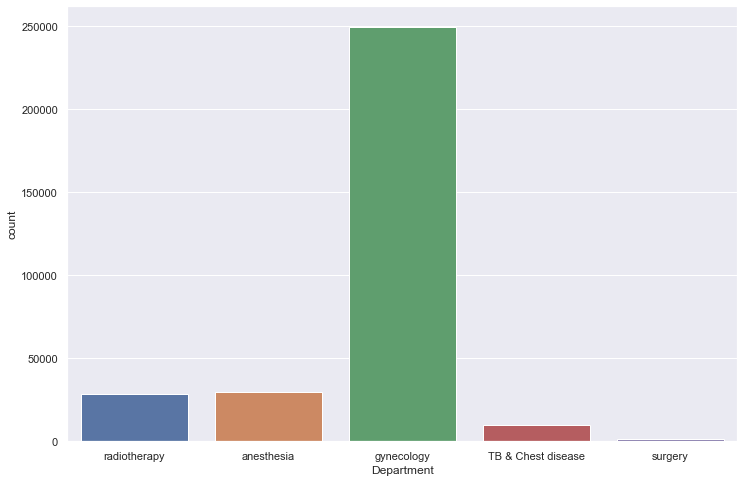

In [167]:
import seaborn as sns

sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.countplot(x='Department', data=tr_hel)

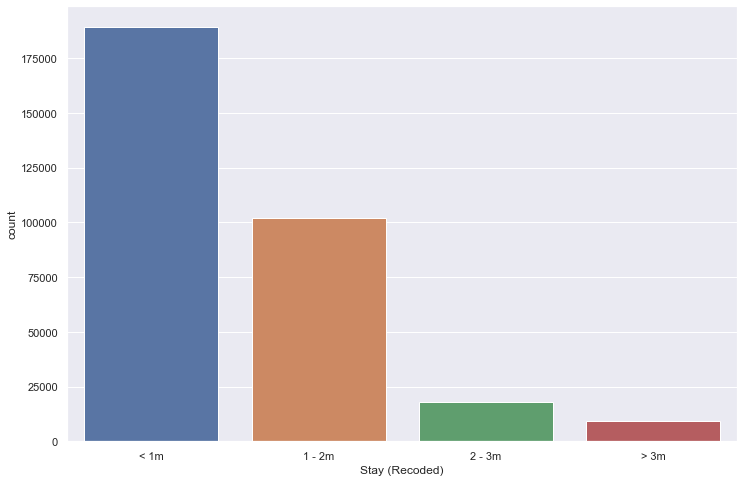

In [169]:
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.countplot(x='Stay (Recoded)', data=tr_hel)

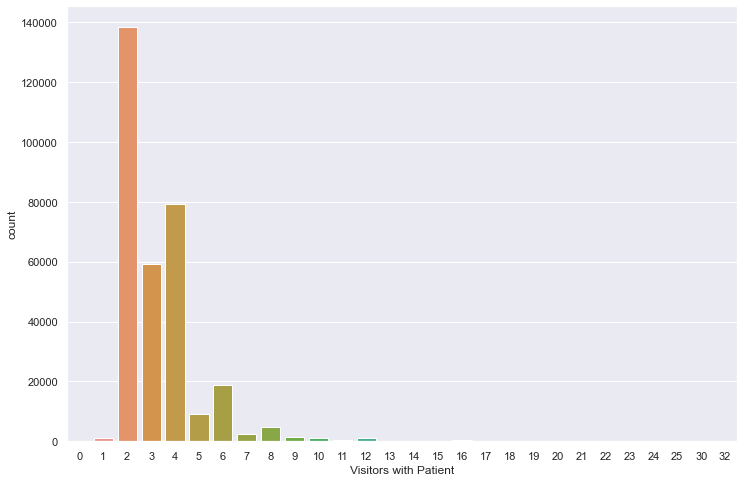

In [170]:
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.countplot(x='Visitors with Patient', data=tr_hel)

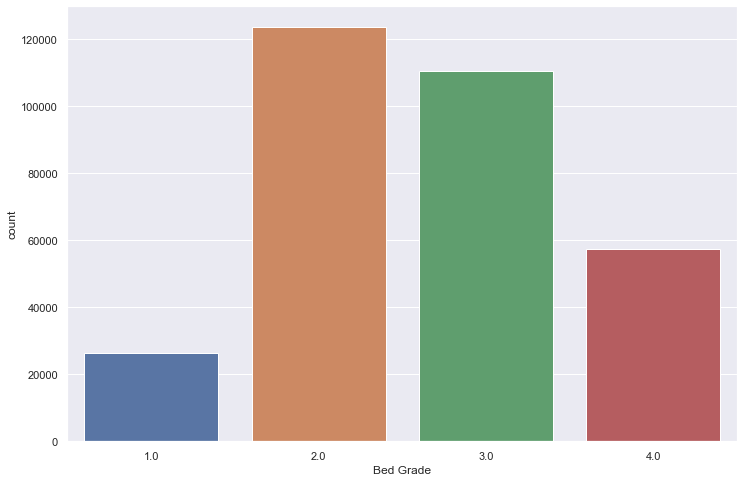

In [172]:
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.countplot(x='Bed Grade', data=tr_hel)

In [228]:
def loadDataset(data, colname, subtype):
    '''Testing dataset'''
    d1, d2 = read_data(data[data[colname] == subtype])
    return d2
def read_data(datatable):
    combination = {}
    dat = []
    for index in datatable.index:

        case = datatable.loc[index]['case_id']
        lastcols = datatable.loc[index][1:]

        var_ids = []
        for variable in list(lastcols.items()):
            if variable[1] == 1:
                var_ids.append(item[0])

        combination[case] = var_ids
        dat.append(var_ids)
    return combination, dat